#  Forecasting using LSTM

In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [4]:
# loading the data and pre-processing it to get desired form
data=pd.read_csv("C:\\Users\\rajes\\Downloads\\long1.csv")   # Loading the data in the environment
cols=["YEAR","MO","DY"]
data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")  # joining the dates into one coloumn
data['date']=pd.to_datetime(data['date'])                                            # converting dates from string to datetime
data=data.drop(['LAT','LON',"YEAR","MO","DY"],axis=1)                                # dropping coloumns which are not required
data.rename(columns = {'ALLSKY_SFC_SW_DWN':'Insolation'}, inplace = True)            # renaming the coloumns
data=data.set_index('date')                                                          # rearranging the coloums
data.head()                                                                          # shows top 5 data from the dataframe

,Insolation
date,
2016-01-01,4.30
2016-01-02,4.23
2016-01-03,4.17
2016-01-04,4.36
2016-01-05,4.15


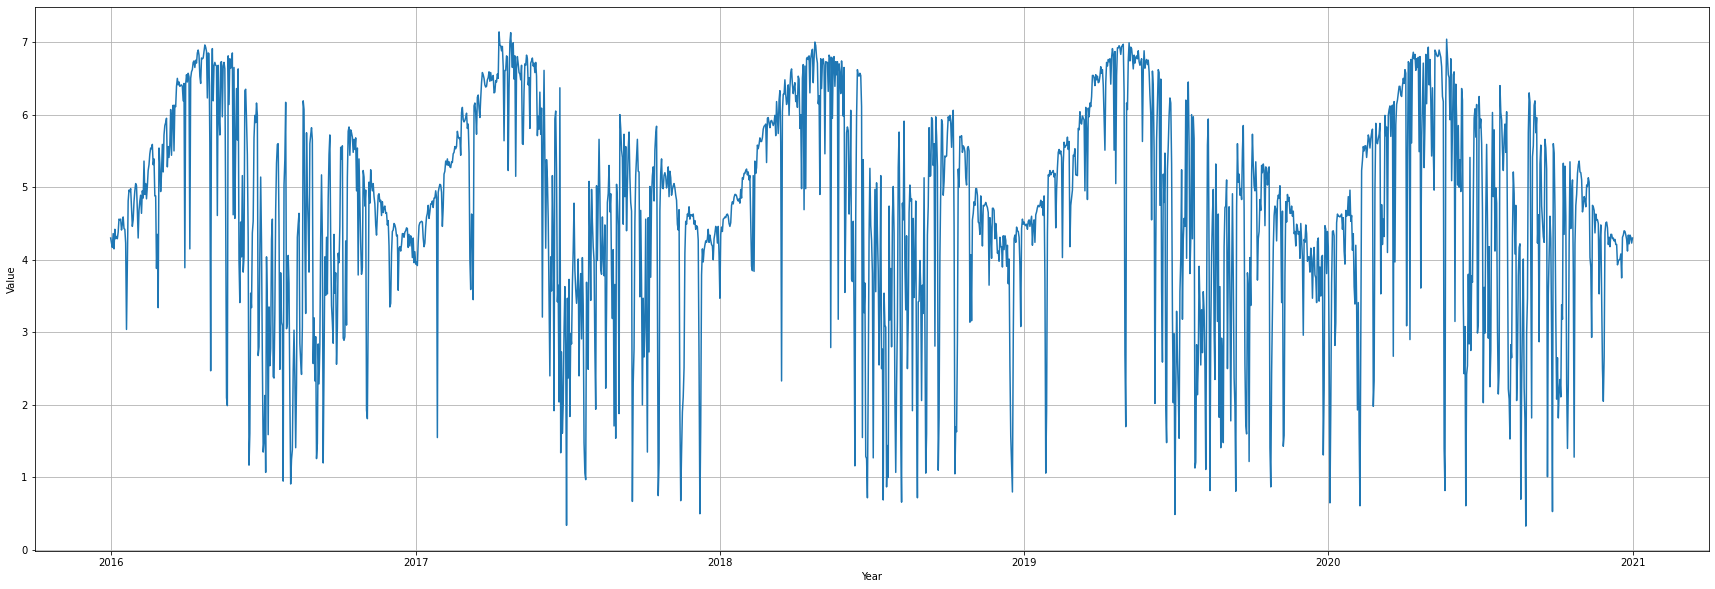

In [5]:
# plotting the series
plt.figure(figsize=(30, 10))
plt.plot( data['Insolation'])
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)

Decomposing the series into 3 components:- <br>
* Trend
* Seasonal
* Residual

In [6]:
# performing decomposition on series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data,  period=365)


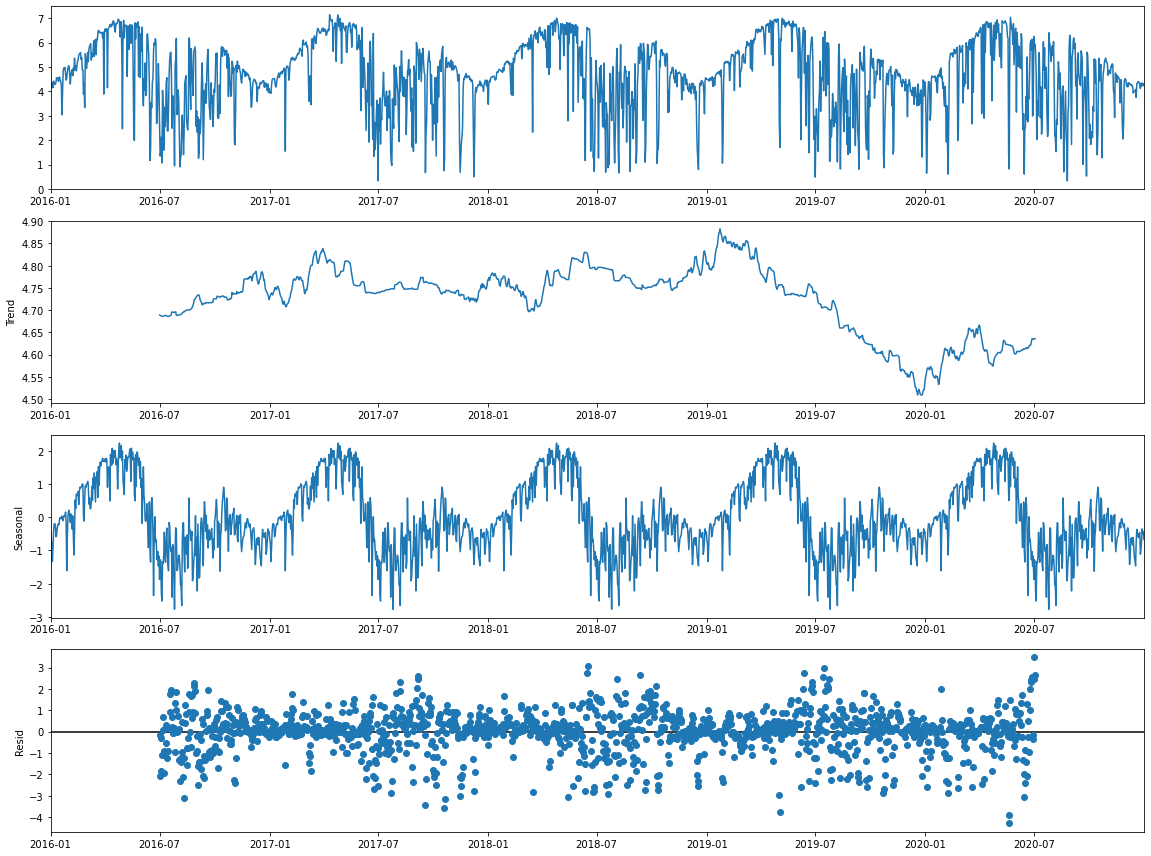

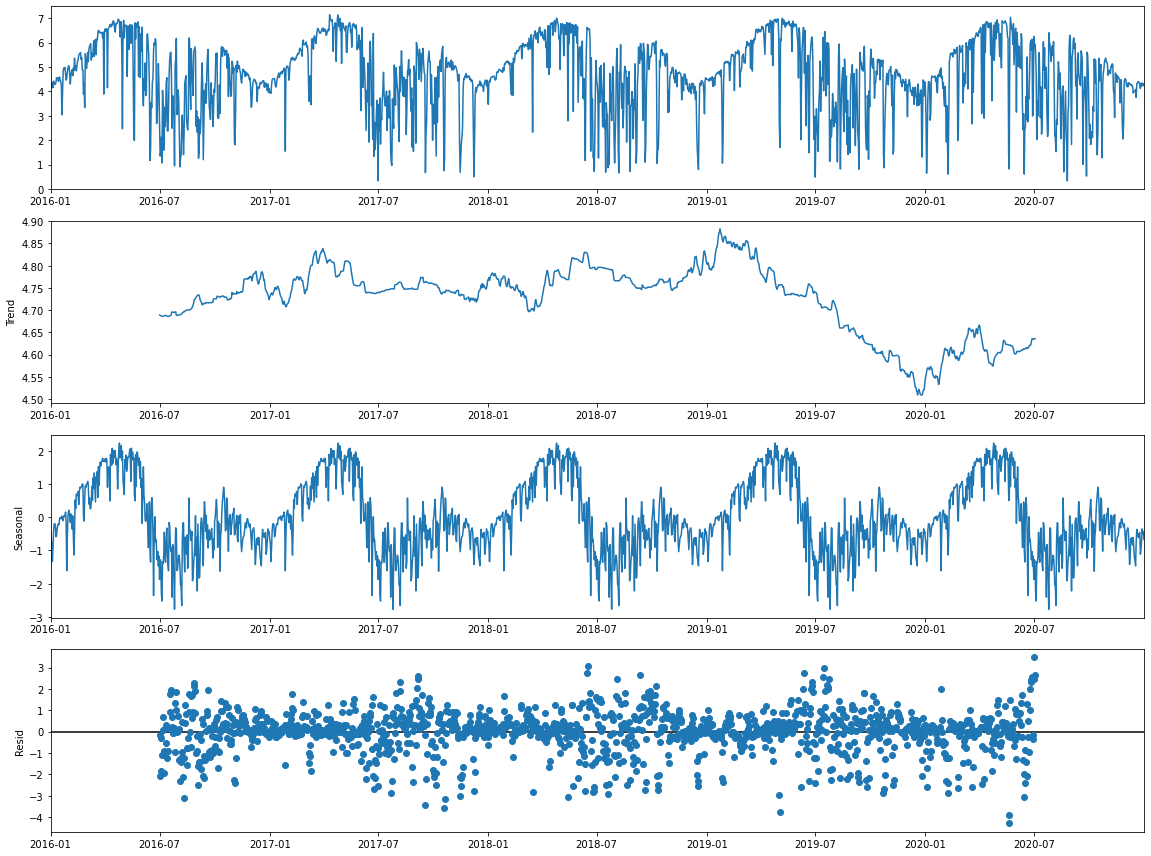

In [7]:
# Ploting decomposed parts
plt.rcParams.update({'figure.figsize': (16,12)})
decomposition.plot()

# Creating dataset for prediction

As the model takes input and output values to train itself, we need to create a dataset of input and output values. Before that we have to divide the dataset into train and test set.

In [8]:
# 80% of data is taken as train set and 20% as test set
n = len(data)
train_df = data['Insolation'][0:int(n*0.8)]
test_df = data['Insolation'][int(n*0.8):]

In [9]:
# converting to array
train_set=train_df.values
test_set=test_df.values


Now, we have to choose a window size, which is the length of input sequences.

In [10]:
win_size=30

In [11]:

x_train=train_set[:-win_size]      # Features of train set 
y_train=train_set[win_size:]       # Labels of train set 

x_val=test_set[:-win_size]         # Features of test set
y_val=test_set[win_size:]          # Labels of test set

In [12]:
# reshaping the array to proper format according to input shape
x_train=np.reshape(x_train,(x_train.shape[0],1))
y_train=np.reshape(y_train,(y_train.shape[0],1))

x_val=np.reshape(x_val,(x_val.shape[0],1))
y_val=np.reshape(y_val,(y_val.shape[0],1))

In [13]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=win_size,
)

In [14]:
val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x_val,
    targets=y_val,
    sequence_length=win_size,
)

In [16]:
for batch in train_dataset:
    inputs, targets = batch

## Model defining and training

In [ ]:
model = keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(inputs.shape[1],inputs.shape[2]))),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1)
])

opt=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss="mse",metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])


In [54]:
# adding callback to save time and computation cost
es_callback = keras.callbacks.EarlyStopping(monitor="val_rmse", min_delta=0, patience=15)

# for saving best version of model
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_rmse",
    filepath="D:\\CET\\major\\model\\New folder\\model.h5",
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [56]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,callbacks=[ modelckpt_callback,es_callback]
)

Epoch 1/100
11/11 [==============================] - 9s 282ms/step - loss: 15.7275 - rmse: 3.8630 - val_loss: 2.4292 - val_rmse: 1.5586

Epoch 00001: val_rmse improved from inf to 1.55860, saving model to D:\CET\major\model\New folder\model.h5
Epoch 2/100
11/11 [==============================] - 2s 165ms/step - loss: 2.2352 - rmse: 1.4934 - val_loss: 2.5239 - val_rmse: 1.5887

Epoch 00002: val_rmse did not improve from 1.55860
Epoch 3/100
11/11 [==============================] - 2s 149ms/step - loss: 2.0300 - rmse: 1.4227 - val_loss: 2.4231 - val_rmse: 1.5566

Epoch 00003: val_rmse improved from 1.55860 to 1.55664, saving model to D:\CET\major\model\New folder\model.h5
Epoch 4/100
11/11 [==============================] - 2s 146ms/step - loss: 2.1103 - rmse: 1.4514 - val_loss: 2.3792 - val_rmse: 1.5425

Epoch 00004: val_rmse improved from 1.55664 to 1.54246, saving model to D:\CET\major\model\New folder\model.h5
Epoch 5/100
11/11 [==============================] - 2s 159ms/step - loss: 

In [32]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

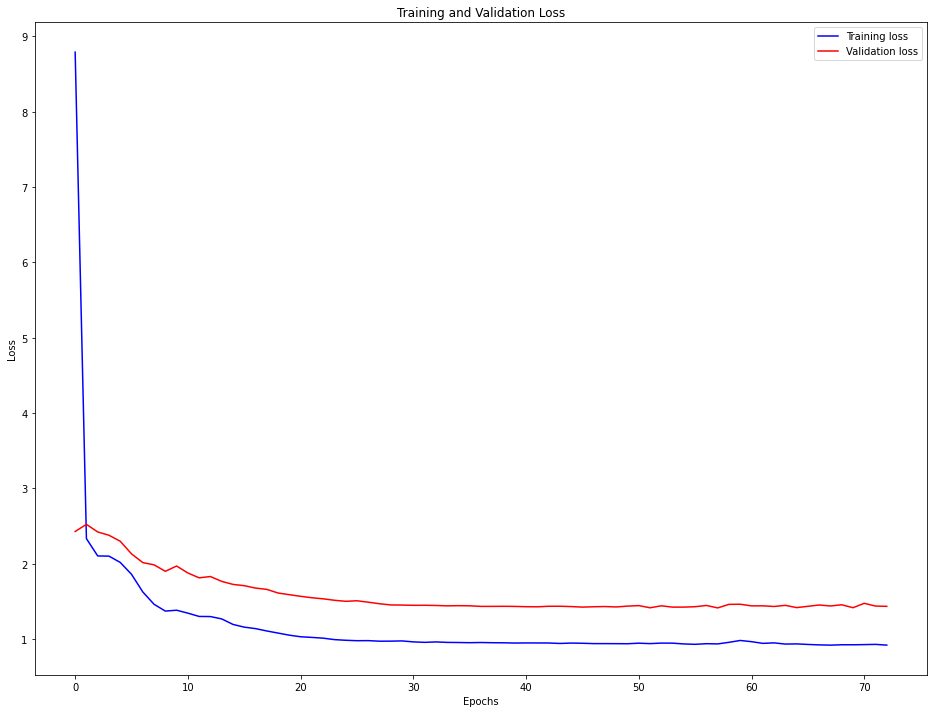

In [57]:
visualize_loss(history, "Training and Validation Loss")

In [58]:
#model.save("D:\\CET\\major\\model\\model.h5")

# Prediction

In [58]:
def predict(model,win_size,data,time_step=10):
    result=[]
    x_new=data[-win_size:]
    x_new=np.reshape(x_new,(1,x_new.shape[0],1))
    
    for i in range(time_step):
        pred=model.predict(x_new[-win_size:])
        result.append(pred[0][0])
        pred=np.reshape(pred,(1,pred.shape[0],1))

        x_new=np.concatenate([x_new, pred], axis=1)
    return result

In [93]:
a=predict(model=model,win_size=win_size,data=y_val,time_step=10)

In [61]:
a

[4.2708125,
 4.281646,
 4.288887,
 4.30406,
 4.3302813,
 4.362599,
 4.3965116,
 4.430758,
 4.4654965,
 4.500568]

# Testing

Comparing the prediction with actual values and calculating the RMSE

In [115]:
# loading the actual values
new_data=pd.read_csv("C:\\Users\\rajes\\Downloads\\march.csv")

In [116]:
# processing to desired form
cols=["YEAR","MO","DY"]
new_data['date'] = new_data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
new_data['date']=pd.to_datetime(new_data['date'])
new_data=new_data.drop(['LAT','LON',"YEAR","MO","DY"],axis=1)
new_data.rename(columns = {'ALLSKY_SFC_SW_DWN':'y','date':'ds'}, inplace = True)
new_data=new_data[['ds','y']]


In [97]:
# storing the actual and predicted values in array
actual_value=new_data['y'][:10].to_numpy()  # storing actual values in the array
pred_value=np.array(a) 

In [99]:
# calculating RMSE
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(actual_value, pred_value)
m.result().numpy()

0.2797358

In [123]:
df=pd.DataFrame({'actual':actual_value,'predicted':pred_value,'diff':abs(actual_value-pred_value)})

In [124]:
df

,actual,predicted,diff
0,4.34,4.270813,0.069187
1,4.40,4.281646,0.118354
2,4.32,4.288887,0.031113
3,4.36,4.304060,0.055940
4,3.92,4.330281,0.410281
5,4.27,4.362599,0.092599
6,3.84,4.396512,0.556512
7,4.12,4.430758,0.310758
8,4.25,4.465497,0.215497
9,4.14,4.500568,0.360568
